In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

# 2023/02/07 Data001 TOF

In [2]:
date = '20230207'
dataNo = 1
scanNo = 1

In [3]:
def create_scan_and_image_data(date,dataNo,scanNo):
    path = r"./"+date
    path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
    path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
    path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
    scan_data = pd.read_csv(path_scan, delimiter='\t')
    param_name ='A0143: LS amplitude (y) 1'
    unit = '[V]'
    scan_param =scan_data[param_name]
    unique_param = np.sort(scan_param.unique())
    flcount = scan_data['Total count1 @ ROI1 (arb. u.)']
    share = Path(path_img)
    if share.exists():
        trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
        flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
        update_files = list(Path(path_img).glob('seq*_update001.tiff'))
    else:
        print('No images')

    img_flat_ave =[]
    img_trans_ave = []
    img_trans_list = []
    for N in range(len(trans_files)):
        img_flat_ave += [np.array(Image.open(flat_files[N]))]
        img_trans_ave += [np.array(Image.open(trans_files[N]))]
    img_flat_ave = np.average(img_flat_ave,axis=0)
    img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
    for N in range(len(trans_files)):
        img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]
    return img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name

img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

In [4]:
x_list = np.arange(-np.shape(img_trans_ave)[0]/2,np.shape(img_trans_ave)[0]/2)
y_list = np.arange(-np.shape(img_trans_ave)[1]/2,np.shape(img_trans_ave)[1]/2)
x_mesh, y_mesh = np.meshgrid(x_list, y_list)

Text(0.5, 1.0, '20230207, DataNo.001, ScanNo.001\n$(J,J^{\\prime})=(1.000,1.000)J_{bare}$')

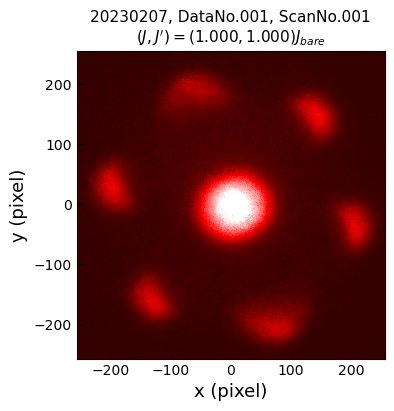

In [5]:
vmin = 0
vmax = 0.8*np.max(img_trans_ave)

title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(1,1)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label,fontsize=11)

Text(0.5, 1.0, 'SeqNo.000')

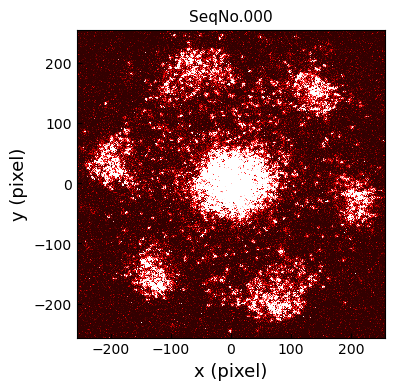

In [6]:
seqNo= 0
vmin = 0
vmax = 2000

title_label_single = 'SeqNo.%03d'%(seqNo)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_list[seqNo], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label_single,fontsize=11)

In [7]:
#フーリエ変換
def FFT(img):
    #フーリエ変換
    fimg = np.fft.fft2(img)
    fimg = np.fft.fftshift(fimg) #低周波成分を中央に寄せる
    #符号を保ったまま対数処理
    real = fimg.real
    real[real>0] = np.log10(real[real>0])
    real[real<0] = -np.log10(-real[real<0])
    imag = fimg.imag
    imag[imag>0] = np.log10(imag[imag>0])
    imag[imag<0] = -np.log10(-imag[imag<0])
    return real, imag

#逆フーリエ変換
def IFFT(real, imag):
    #符号を保ったまま指数処理
    real[real>0] = 10**real[real>0]
    real[real<0] = -10**(-real[real<0])
    imag[imag>0] = 10**imag[imag>0]
    imag[imag<0] = -10**(-imag[imag<0])
    #複素数行列
    fimg = np.zeros(real.shape, np.complex128)
    fimg.real = real
    fimg.imag = imag
    #逆フーリエ変換
    fimg = np.fft.ifftshift(fimg)
    img = np.fft.ifft2(fimg)
    img = img.real
    img = img.clip(0, 255).astype(np.uint8)
    return img

In [8]:
xmin_FFT = 0
xmax_FFT = np.shape(img_trans_ave)[0]-0
ymin_FFT = 0
ymax_FFT = np.shape(img_trans_ave)[1]-0
xcenter_FFT = (xmax_FFT-xmin_FFT)/2
ycenter_FFT = (ymax_FFT-ymin_FFT)/2
side = 30

In [9]:
def create_fft_image(img_trans_list):
    fft_img_list = []
    for i in range(len(img_trans_list)):
        img_tmp = img_trans_list[i]
        img_tmp = img_tmp[xmin_FFT:xmax_FFT,ymin_FFT:ymax_FFT]
        real, imag = FFT(img_tmp)
        fimg = np.zeros(real.shape, np.complex128)
        fimg.real = real
        fimg.imag = imag
        img = np.abs(fimg)
        fft_img_list.append(img)
    return fft_img_list
fft_img_list = create_fft_image(img_trans_list)
fft_img_ave=np.average(fft_img_list,axis=0)

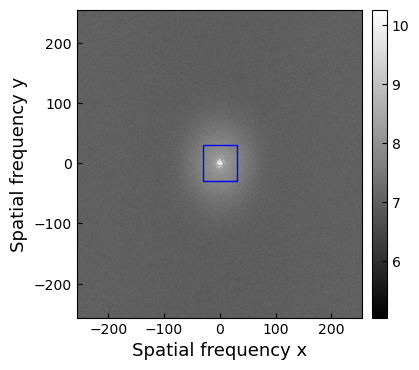

In [10]:
fig = plt.figure(figsize=[4,4],dpi=100)
ax = fig.add_subplot(1,1,1)
mappable = ax.pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=np.min(fft_img_ave), vmax=np.max(fft_img_ave),cmap="gray")
ax.set_ylabel("Spatial frequency y",fontsize=13)
ax.set_xlabel("Spatial frequency x",fontsize=13)
ax.tick_params(axis='both',direction='in')
divider1 = make_axes_locatable(ax)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
pp=fig.colorbar(mappable,cax=ax_cb1)
ax_cb1.tick_params(axis='y',direction='in')
region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
region.plot(ax=ax, color='blue', lw=1, linestyle = '-')

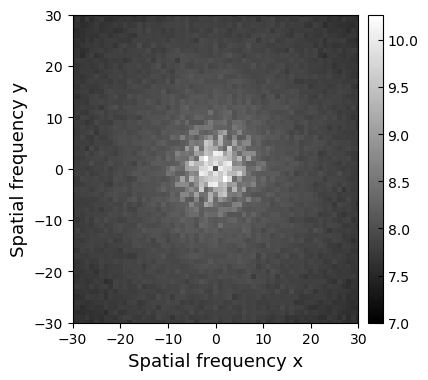

In [11]:
fig = plt.figure(figsize=[4,4],dpi=100)
ax = fig.add_subplot(1,1,1)
mappable = ax.pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=7.0, vmax=np.max(fft_img_ave),cmap="gray")
ax.set_xlim(-side,side)
ax.set_ylim(-side,side)
ax.set_ylabel("Spatial frequency y",fontsize=13)
ax.set_xlabel("Spatial frequency x",fontsize=13)
divider1 = make_axes_locatable(ax)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
pp=fig.colorbar(mappable,cax=ax_cb1)
ax_cb1.tick_params(axis='y',direction='in')

In [12]:
averaged_TOF_image_list = []
averaged_FFT_image_list = []
single_TOF_image_list = []
TOF_title_label_list = []
single_TOF_title_label_list = []

averaged_TOF_image_list.append(img_trans_ave)
averaged_FFT_image_list.append(fft_img_ave)
single_TOF_image_list.append(img_trans_list[seqNo])
TOF_title_label_list.append(title_label)
single_TOF_title_label_list.append(title_label_single)

## 2023/02/08 Data001 In-situ

In [13]:
date = '20230208'
dataNo = 1
scanNo = 1
img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

Text(0.5, 1.0, '20230208, DataNo.001, ScanNo.001')

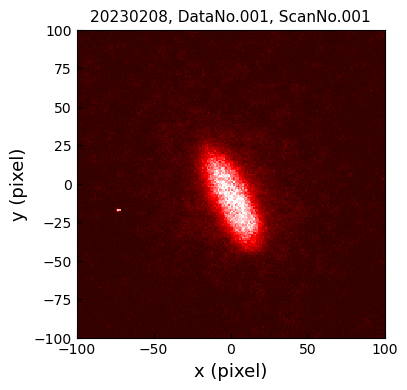

In [14]:
xlim_1 = -100
xlim_2 = 100
ylim_1 = -100
ylim_2 = 100
vmin = 0
vmax = 0.8*np.max(img_trans_ave)

title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label,fontsize=11)

In [15]:
averaged_InSitu_image_list = []
Insitu_title_label_list = []

averaged_InSitu_image_list.append(img_trans_ave)
Insitu_title_label_list.append(title_label)

# 2023/02/08 Data002 TOF

In [16]:
date = '20230208'
dataNo = 2
scanNo = 2
img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

Text(0.5, 1.0, '20230208, DataNo.002, ScanNo.002\n$(J,J^{\\prime})=(1.000,1.000)J_{bare}$')

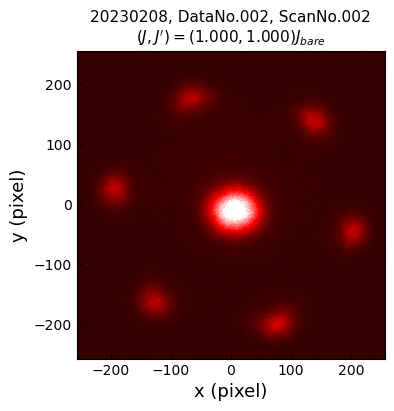

In [17]:
vmin = 0
vmax = 0.8*np.max(img_trans_ave)

title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(1,1)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label,fontsize=11)

Text(0.5, 1.0, 'SeqNo.000')

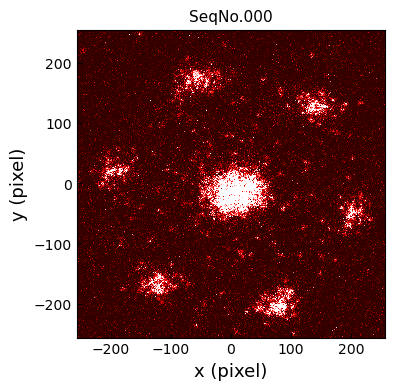

In [18]:
seqNo= 0 
vmin = 0
vmax = 2000

title_label_single = 'SeqNo.%03d'%(seqNo)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_list[seqNo], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label_single,fontsize=11)

In [19]:
fft_img_list = create_fft_image(img_trans_list)
fft_img_ave=np.average(fft_img_list,axis=0)

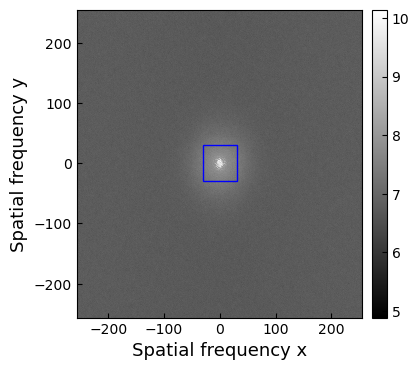

In [20]:
fig = plt.figure(figsize=[4,4],dpi=100)
ax = fig.add_subplot(1,1,1)
mappable = ax.pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=np.min(fft_img_ave), vmax=np.max(fft_img_ave),cmap="gray")
ax.set_ylabel("Spatial frequency y",fontsize=13)
ax.set_xlabel("Spatial frequency x",fontsize=13)
ax.tick_params(axis='both',direction='in')
divider1 = make_axes_locatable(ax)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
pp=fig.colorbar(mappable,cax=ax_cb1)
ax_cb1.tick_params(axis='y',direction='in')
region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
region.plot(ax=ax, color='blue', lw=1, linestyle = '-')

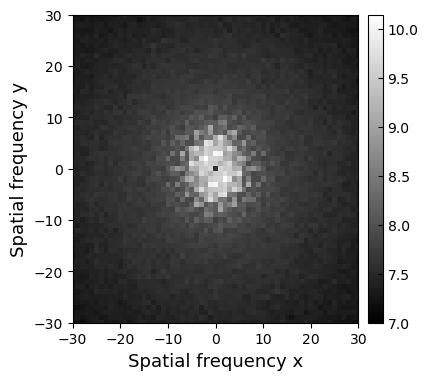

In [21]:
fig = plt.figure(figsize=[4,4],dpi=100)
ax = fig.add_subplot(1,1,1)
mappable = ax.pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=7.0, vmax=np.max(fft_img_ave),cmap="gray")
ax.set_xlim(-side,side)
ax.set_ylim(-side,side)
ax.set_ylabel("Spatial frequency y",fontsize=13)
ax.set_xlabel("Spatial frequency x",fontsize=13)
divider1 = make_axes_locatable(ax)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
pp=fig.colorbar(mappable,cax=ax_cb1)
ax_cb1.tick_params(axis='y',direction='in')

In [22]:
averaged_TOF_image_list.append(img_trans_ave)
averaged_FFT_image_list.append(fft_img_ave)
single_TOF_image_list.append(img_trans_list[seqNo])
TOF_title_label_list.append(title_label)
single_TOF_title_label_list.append(title_label_single)

# 2023/02/08 Data003 In-situ

In [23]:
date = '20230208'
dataNo = 3
scanNo = 3
img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

Text(0.5, 1.0, '20230208, DataNo.003, ScanNo.003')

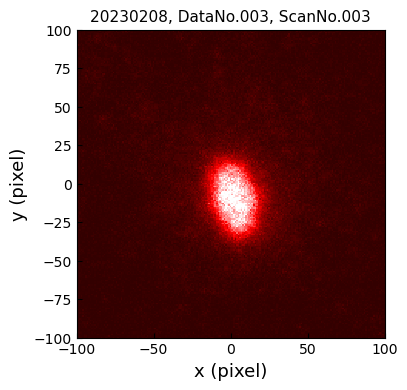

In [24]:
xlim_1 = -100
xlim_2 = 100
ylim_1 = -100
ylim_2 = 100
vmin = 0
vmax = 0.8*np.max(img_trans_ave)

title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label,fontsize=11)

In [25]:
averaged_InSitu_image_list.append(img_trans_ave)
Insitu_title_label_list.append(title_label)

# 2023/02/08 Data004 TOF

In [26]:
date = '20230208'
dataNo = 4
scanNo = 4
img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

Text(0.5, 1.0, '20230208, DataNo.004, ScanNo.004\n$(J,J^{\\prime})=(1.000,1.000)J_{bare}$')

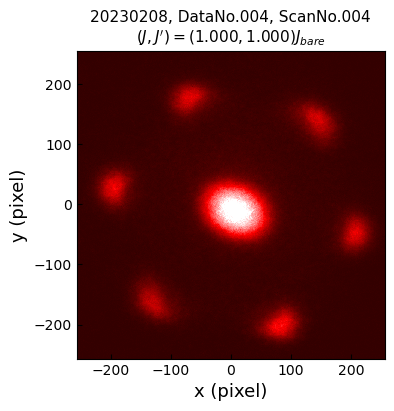

In [27]:
vmin = 0
vmax = 0.8*np.max(img_trans_ave)

title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(1,1)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label,fontsize=11)

Text(0.5, 1.0, 'SeqNo.000')

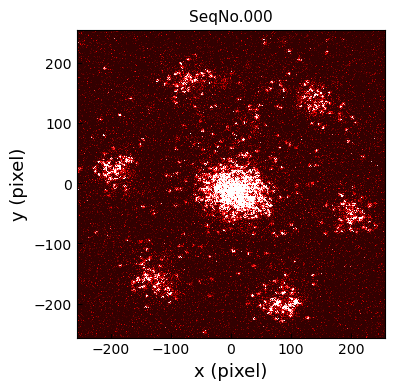

In [28]:
seqNo= 0
vmin = 0
vmax = 2000

title_label_single = 'SeqNo.%03d'%(seqNo)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_list[seqNo], cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label_single,fontsize=11)

In [29]:
fft_img_list = create_fft_image(img_trans_list)
fft_img_ave=np.average(fft_img_list,axis=0)

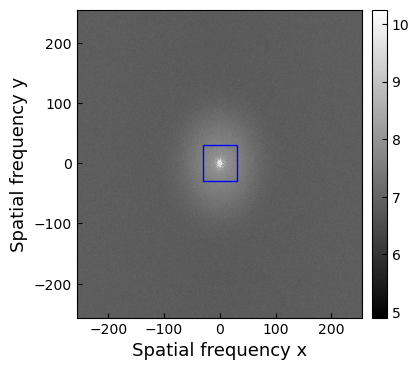

In [30]:
fig = plt.figure(figsize=[4,4],dpi=100)
ax = fig.add_subplot(1,1,1)
mappable = ax.pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=np.min(fft_img_ave), vmax=np.max(fft_img_ave),cmap="gray")
ax.set_ylabel("Spatial frequency y",fontsize=13)
ax.set_xlabel("Spatial frequency x",fontsize=13)
ax.tick_params(axis='both',direction='in')
divider1 = make_axes_locatable(ax)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
pp=fig.colorbar(mappable,cax=ax_cb1)
ax_cb1.tick_params(axis='y',direction='in')
region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
region.plot(ax=ax, color='blue', lw=1, linestyle = '-')

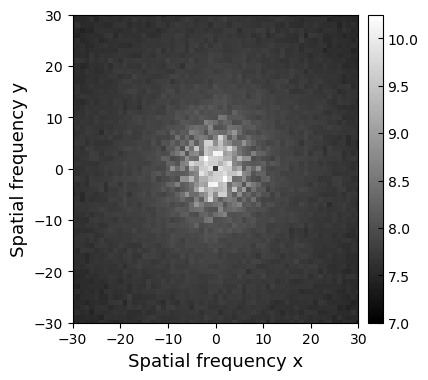

In [31]:
fig = plt.figure(figsize=[4,4],dpi=100)
ax = fig.add_subplot(1,1,1)
mappable = ax.pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=7.0, vmax=np.max(fft_img_ave),cmap="gray")
ax.set_xlim(-side,side)
ax.set_ylim(-side,side)
ax.set_ylabel("Spatial frequency y",fontsize=13)
ax.set_xlabel("Spatial frequency x",fontsize=13)
divider1 = make_axes_locatable(ax)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
pp=fig.colorbar(mappable,cax=ax_cb1)
ax_cb1.tick_params(axis='y',direction='in')

In [32]:
averaged_TOF_image_list.append(img_trans_ave)
averaged_FFT_image_list.append(fft_img_ave)
single_TOF_image_list.append(img_trans_list[seqNo])
TOF_title_label_list.append(title_label)
single_TOF_title_label_list.append(title_label_single)

# 2023/02/08 Data05 In-situ

In [33]:
date = '20230208'
dataNo = 5
scanNo = 5
img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

Text(0.5, 1.0, '20230208, DataNo.005, ScanNo.005')

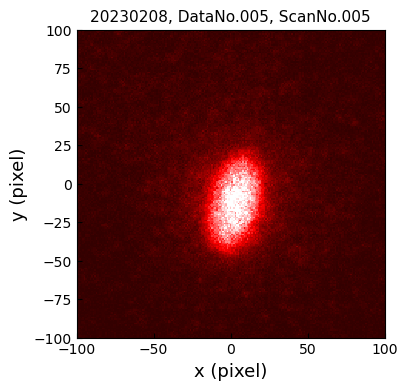

In [34]:
xlim_1 = -100
xlim_2 = 100
ylim_1 = -100
ylim_2 = 100
vmin = 0
vmax = 0.8*np.max(img_trans_ave)

title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)

fig =plt.figure(figsize=[4,4])
ax1 = fig.add_subplot(1,1,1)
mappable =ax1.pcolormesh(x_mesh,y_mesh,img_trans_ave, cmap=cmap,vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(xlim_1,xlim_2)
ax1.set_ylim(ylim_1,ylim_2)
ax1.tick_params(axis='both',direction='in')
ax1.set_xlabel('x (pixel)',fontsize=13)
ax1.set_ylabel('y (pixel)',fontsize=13)
ax1.set_title(title_label,fontsize=11)

In [35]:
averaged_InSitu_image_list.append(img_trans_ave)
Insitu_title_label_list.append(title_label)

# Summary

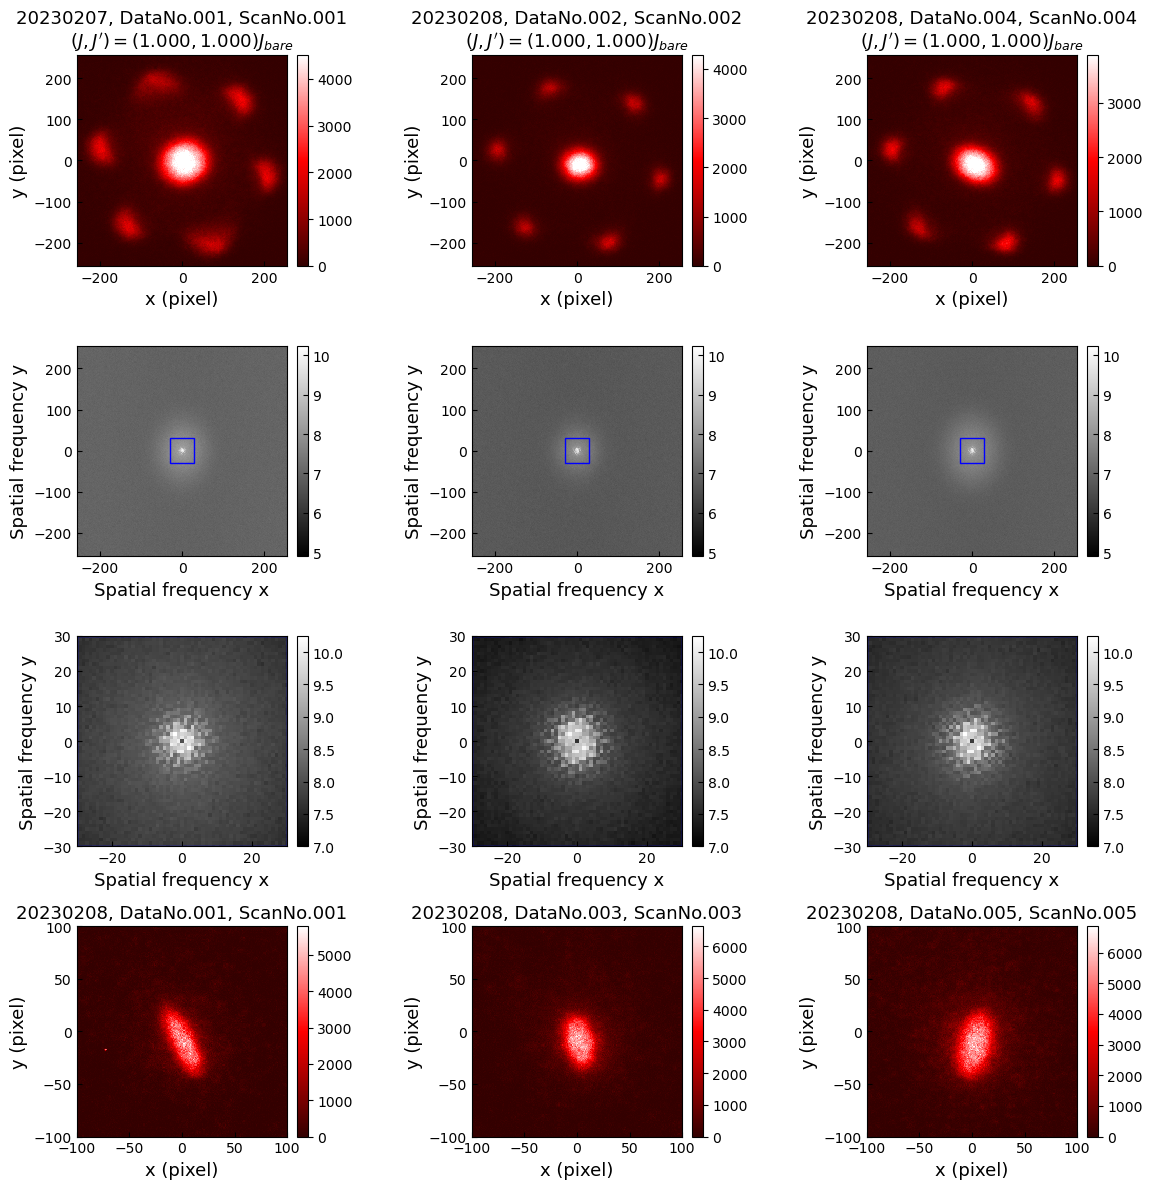

In [36]:
column_number = 3
row_number = 4

fig, axes = plt.subplots(row_number, column_number, figsize=(12,12),dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(column_number):
    for j in range(row_number):
        if j==0:
            vmax=0.8*np.max(averaged_TOF_image_list[i])
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_TOF_image_list[i], cmap=cmap,vmin=0, vmax=vmax, shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].tick_params(axis='both',direction='in')
            axes[j,i].set_xlabel('x (pixel)',fontsize=13)
            axes[j,i].set_ylabel('y (pixel)',fontsize=13)
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            axes[j,i].set_title(TOF_title_label_list[i],fontsize=13)
        elif j==1:
            vmax=np.max(averaged_FFT_image_list[i])
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_FFT_image_list[i],vmin=np.min(fft_img_ave), vmax=np.max(fft_img_ave),cmap="gray")
            axes[j,i].set_aspect('equal')
            axes[j,i].set_ylabel("Spatial frequency y",fontsize=13)
            axes[j,i].set_xlabel("Spatial frequency x",fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
            region.plot(ax=axes[j,i], color='blue', lw=1, linestyle = '-')
        elif j==2:
            vmax = np.max(averaged_FFT_image_list[i])
            vmin = 7.0
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_FFT_image_list[i],vmin=vmin, vmax=np.max(fft_img_ave),cmap="gray")
            axes[j,i].set_xlim(-side,side)
            axes[j,i].set_ylim(-side,side)
            axes[j,i].set_aspect('equal')
            axes[j,i].set_ylabel("Spatial frequency y",fontsize=13)
            axes[j,i].set_xlabel("Spatial frequency x",fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
            region.plot(ax=axes[j,i], color='blue', lw=1, linestyle = '-')
        else:
            vmax=np.max(averaged_InSitu_image_list[i])
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_InSitu_image_list[i], cmap=cmap,vmin=0, vmax=vmax, shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].tick_params(axis='both',direction='in')
            axes[j,i].set_xlabel('x (pixel)',fontsize=13)
            axes[j,i].set_ylabel('y (pixel)',fontsize=13)
            axes[j,i].set_xlim(xlim_1,xlim_2)
            axes[j,i].set_ylim(ylim_1,ylim_2)
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            axes[j,i].set_title(Insitu_title_label_list[i],fontsize=13)


plt.tight_layout()

# plt.savefig("SpinDomain.png")

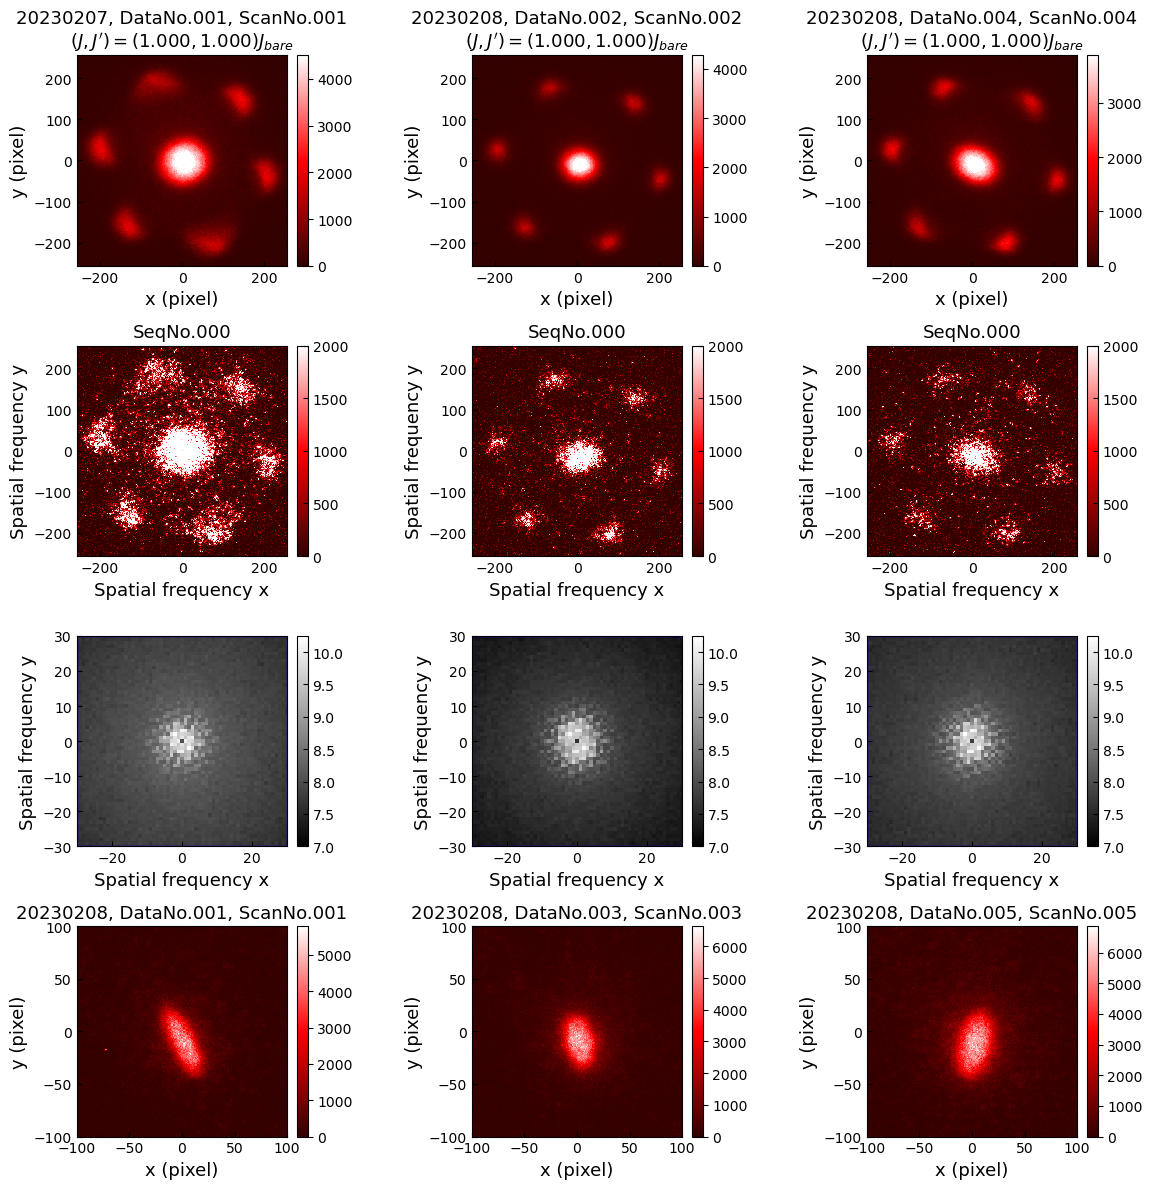

In [38]:
column_number = 3
row_number = 4

fig, axes = plt.subplots(row_number, column_number, figsize=(12,12),dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(column_number):
    for j in range(row_number):
        if j==0:
            vmax=0.8*np.max(averaged_TOF_image_list[i])
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_TOF_image_list[i], cmap=cmap,vmin=0, vmax=vmax, shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].tick_params(axis='both',direction='in')
            axes[j,i].set_xlabel('x (pixel)',fontsize=13)
            axes[j,i].set_ylabel('y (pixel)',fontsize=13)
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            axes[j,i].set_title(TOF_title_label_list[i],fontsize=13)
        elif j==1:
            vmax=2000
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,single_TOF_image_list[i], cmap=cmap,vmin=0, vmax=vmax, shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].set_ylabel("Spatial frequency y",fontsize=13)
            axes[j,i].set_xlabel("Spatial frequency x",fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            axes[j,i].set_title(single_TOF_title_label_list[i],fontsize=13)
        elif j==2:
            vmax = np.max(averaged_FFT_image_list[i])
            vmin = 7.0
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_FFT_image_list[i],vmin=vmin, vmax=np.max(fft_img_ave),cmap="gray")
            axes[j,i].set_xlim(-side,side)
            axes[j,i].set_ylim(-side,side)
            axes[j,i].set_aspect('equal')
            axes[j,i].set_ylabel("Spatial frequency y",fontsize=13)
            axes[j,i].set_xlabel("Spatial frequency x",fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
            region.plot(ax=axes[j,i], color='blue', lw=1, linestyle = '-')
        else:
            vmax=np.max(averaged_InSitu_image_list[i])
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,averaged_InSitu_image_list[i], cmap=cmap,vmin=0, vmax=vmax, shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].tick_params(axis='both',direction='in')
            axes[j,i].set_xlabel('x (pixel)',fontsize=13)
            axes[j,i].set_ylabel('y (pixel)',fontsize=13)
            axes[j,i].set_xlim(xlim_1,xlim_2)
            axes[j,i].set_ylim(ylim_1,ylim_2)
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            axes[j,i].set_title(Insitu_title_label_list[i],fontsize=13)


plt.tight_layout()